<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/Ensemble/ensemble_2024_01_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [3]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet


  Preparing metadata (setup.py) ... done


In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *

print('VOCAB TYPE:', VOCAB_TYPE)

VOCAB TYPE: smiles


In [13]:
M5 = ['CYP2C19_Veith',
        'CYP2D6_Veith',
        'CYP3A4_Veith',
        'CYP1A2_Veith',
        'CYP2C9_Veith']

model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']
import pandas as pd
trn, val, tst = collect_data(M5)

In [56]:
# temp_df = pd.DataFrame()
# temp_df['Drug'] = tst['Drug'].tolist()
# df_list = [temp_df.copy()] * len(M5)

def process_ensemble(tst):

    df_list = []
    for i in range(len(M5)):
        # print(i, M5[i])

        # append true labels into df_list
        temp_df = pd.DataFrame()
        temp_df['Drug'] = tst['Drug'].tolist()
        temp_df[M5[i]] = tst[M5[i]].tolist()
        df_list.append(temp_df)

    for model_type in model_types[:3]:
        file_name = f'M5/uw/{model_type}_MT_1.yml'
        with open(file_name, 'r') as f: yml_data = yaml.safe_load(f)
        models = PRED(**yml_data['config'])
        models.load_status(yml_data)

        df = models.predict(tst['Drug'].tolist(), return_probs=True)
        for j in range(len(M5)):
            df_list[j][model_type] = df[M5[j]].tolist()
    return df_list


In [58]:

train_list = process_ensemble(trn)


Model type:  MLP | Model parameters:  32453
finish load data status 

load pretrained model from  M5/uw/MLP_MT_1.pt
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


Predicting...: 100%|██████████| 250/250 [00:02<00:00, 95.69it/s]


Model type:  AttentiveFP | Model parameters:  3824711
finish load data status 

load pretrained model from  M5/uw/AttentiveFP_MT_1.pt
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 1300 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done 5300 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 10900 tasks      | elapsed:   15.8s
[Parallel(n_jobs=10)]: Done 15984 out of 15984 | elapsed:   20.0s finished
Predicting...: 100%|██████████| 250/250 [00:04<00:00, 54.90it/s]


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 74.9MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978801
finish load data status 

load pretrained model from  M5/uw/GIN_MT_1.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 250/250 [00:35<00:00,  7.05it/s]


In [59]:
train_list[0]

,Drug,CYP2C19_Veith,MLP,AttentiveFP,GIN
0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1.0,0.910261,0.646759,0.925624
1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1.0,0.893791,0.860558,0.916108
2,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1.0,0.830462,0.788558,0.900587
3,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0.0,0.856154,0.121131,0.375326
4,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,0.0,0.749326,0.108142,0.374205
...,...,...,...,...,...
15979,CC(C)=CCC/C(C)=C/CO/N=C1/C[C@@H](O)[C@@H](O)[C...,NaN,0.062525,0.048919,0.067832
15980,CCN1C(=O)[C@H]2CC[C@@H]3/C(=N\OC[C@@H](O)COCc4...,NaN,0.052289,0.025250,0.007245
15981,COc1ccc(COC(=O)N/N=C2/C[C@@H](O)[C@@H](O)[C@@H...,NaN,0.006179,0.011527,0.026620
15982,CCN1C(=O)[C@H]2CC[C@H]3/C(=N\O[C@@H]4O[C@@H](C...,NaN,0.017914,0.000175,0.014634


In [60]:
valid_list = process_ensemble(val)

Model type:  MLP | Model parameters:  32453
finish load data status 

load pretrained model from  M5/uw/MLP_MT_1.pt
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


Predicting...: 100%|██████████| 85/85 [00:00<00:00, 95.59it/s]
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Model type:  AttentiveFP | Model parameters:  3824711
finish load data status 

load pretrained model from  M5/uw/AttentiveFP_MT_1.pt
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 5384 out of 5384 | elapsed:    4.6s finished
Predicting...: 100%|██████████| 85/85 [00:01<00:00, 55.04it/s]


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 66.7MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978801
finish load data status 

load pretrained model from  M5/uw/GIN_MT_1.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 85/85 [00:11<00:00,  7.14it/s]


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ensemble_dataset(Dataset):
    def __init__(self, df, task_name, mask=MASK, header=model_types):
        super(ensemble_dataset, self).__init__()

        self.df = df.copy().fillna(mask)
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[[task_name]]
    def __len__(self): return self.len
    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label


In [72]:
a = ensemble_dataset(df_list[0], M5[0], header=model_types[:3])

In [73]:
batch_size = 64
params_ = {'batch_size': batch_size, 'shuffle': True,
               'drop_last': False, 'num_workers': 0}
trn_l = DataLoader(ensemble_dataset(train_list[0], M5[0], header=model_types[:3]), **params_)
val_l = DataLoader(ensemble_dataset(valid_list[0], M5[0], header=model_types[:3]), **params_)
tst_l = DataLoader(ensemble_dataset(df_list[0], M5[0], header=model_types[:3]), **params_)

In [ ]:
for i, j in trn_l:
    print(i, j)
    break

In [88]:

config_ensemble = {
    'in_dim': len(model_types[:3]),
    'out_dim': 1,
    'hid_dims': [64, 32, 16],
    'dropout': 0.1,
    'model_type': 'MLP',
    'prop_names': [M5[0]],
    'IS_R': names_dict[M5[0]],
    'batch_size': 64,
    'lr': 5e-5,
    'wd': 1e-5,
    'patience': 10,
    'verbose_freq': 100,
    'model_path': f'ckpt_ensemble.pt',
    'weight_loss': [1.0],
    'uncertainty_weight': False,
    'scale_dict': None}
# model_ensemble = Classifier(**config_ensemble).to('cuda')
models = PRED(**config_ensemble)

Model type:  MLP | Model parameters:  2881


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...



Run # 0 for RNN MT	 | save dir:  M5/uw/RNN_MT_0 | 	cannot open M5/uw/RNN_MT_0.yml, retrain
collect data for:  ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']


Done!


No scaling
---> loader for ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  2981257
Start training RNN...
Epoch:0 [Train] Loss: 0.639 | [Valid] Loss: 0.588	SAVE MODEL: loss: inf -> 0.588 | runtime: 1.217 ms
Epoch:1 [Train] Loss: 0.568 | [Valid] Loss: 0.558	SAVE MODEL: loss: 0.588 -> 0.558 | runtime: 1.231 ms
Epoch:2 [Train] Loss: 0.533 | [Valid] Loss: 0.527	SAVE MODEL: loss: 0.558 -> 0.527 | runtime: 1.232 ms
Epoch:3 [Train] Loss: 0.516 | [Valid] Loss: 0.527	SAVE MODEL: loss: 0.527 -> 0.527 | runtime: 1.198 ms
Epoch:4 [Train] Loss: 0.506 | [Valid] Loss: 0.511	SAVE MODEL: loss: 0.527 -> 0.511 | runtime: 1.181 ms
Epoch:5 [Train] Loss: 0.501 | [Valid] Loss: 0.514	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.497 | [Valid] Loss: 0.503	SAVE MODEL: loss: 0.511 -> 0.503 | ru

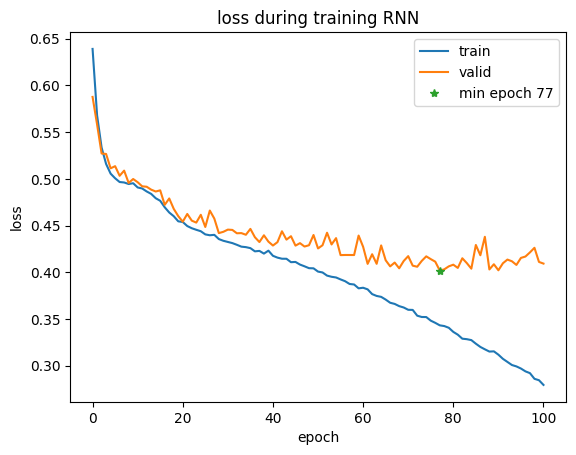

*************** CYP2C19_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.822  &0.822  &0.811  &0.809  &0.834  &0.810 &0.888 &0.643 &0.861

*************** CYP2D6_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.856  &0.735  &0.671  &0.535  &0.935  &0.595 &0.848 &0.514 &0.685

*************** CYP3A4_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.801  &0.796  &0.763  &0.762  &0.830  &0.762 &0.875 &0.592 &0.830

*************** CYP1A2_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.819  &0.819  &0.793  &0.823  &0.815  &0.807 &0.898 &0.637 &0.883

*************** CYP2C9_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.844  &0.814  &0.801  &0.722  &0.907  &0.759 &0.907 &0.646 &0.822

Epoch:101 [Train] Loss: 0.279 | [Valid] Loss: 0.418	EarlyStopping counter: 24 out of 30
Epoch:102 [

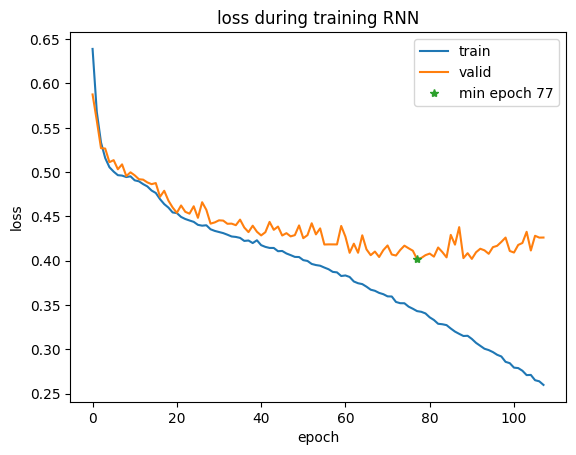

load pretrained model from  M5/uw/RNN_MT_0.pt
[Test] Loss: 0.272
*************** CYP2C19_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.792  &0.794  &0.751  &0.819  &0.770  &0.784 &0.872 &0.587 &0.839


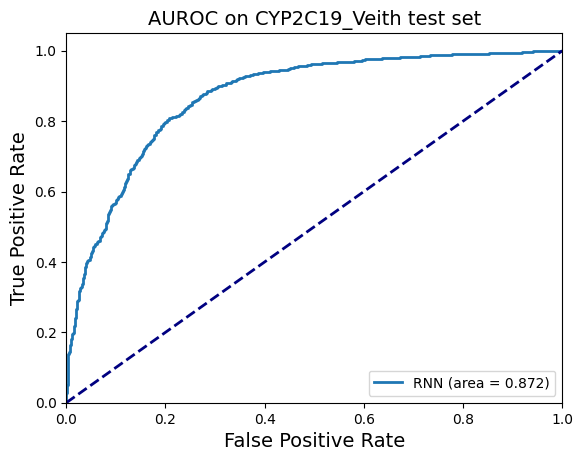

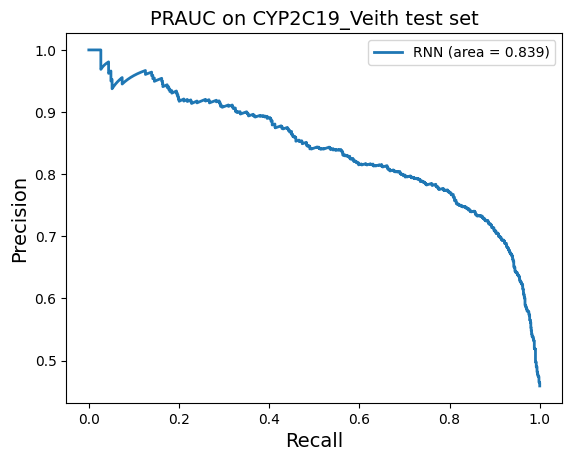


*************** CYP2D6_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.858  &0.711  &0.664  &0.477  &0.945  &0.555 &0.824 &0.483 &0.616


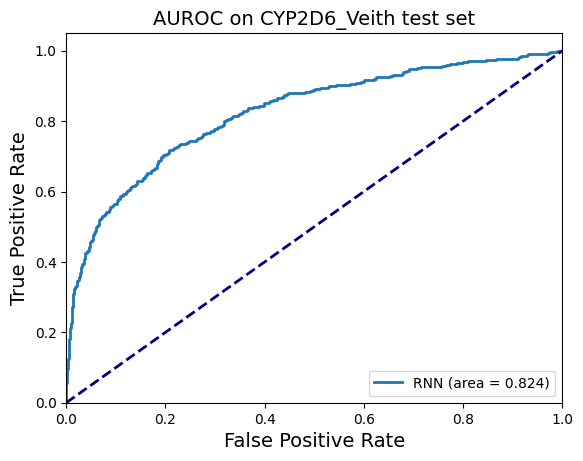

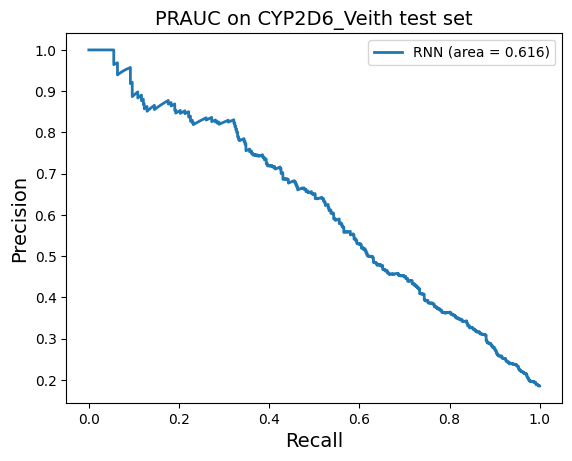


*************** CYP3A4_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.775  &0.772  &0.714  &0.757  &0.787  &0.735 &0.859 &0.540 &0.809


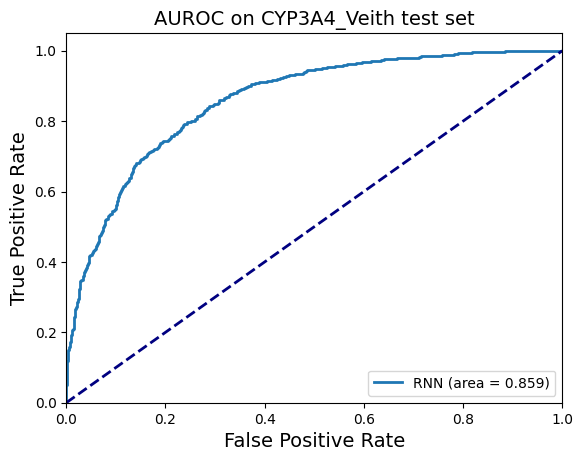

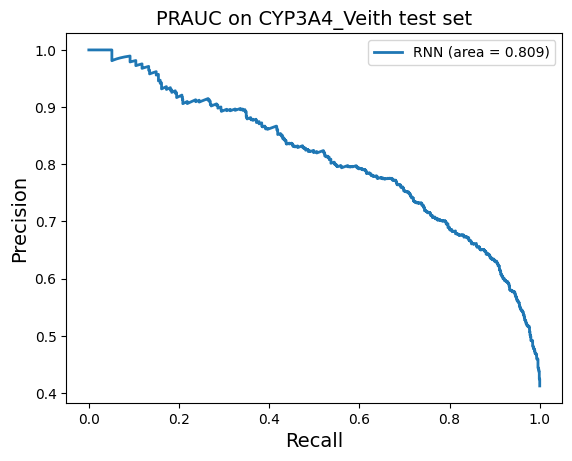


*************** CYP1A2_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.839  &0.840  &0.813  &0.855  &0.824  &0.833 &0.920 &0.678 &0.913


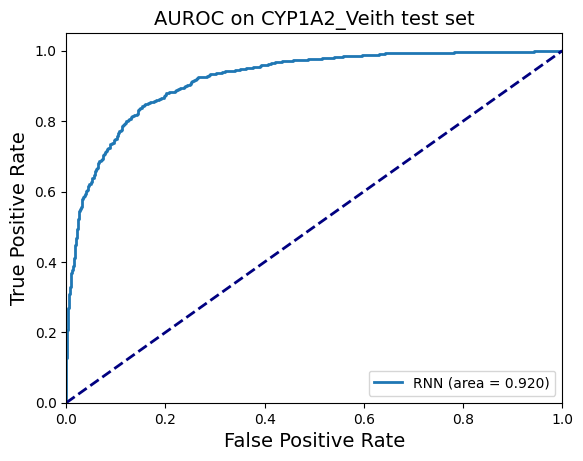

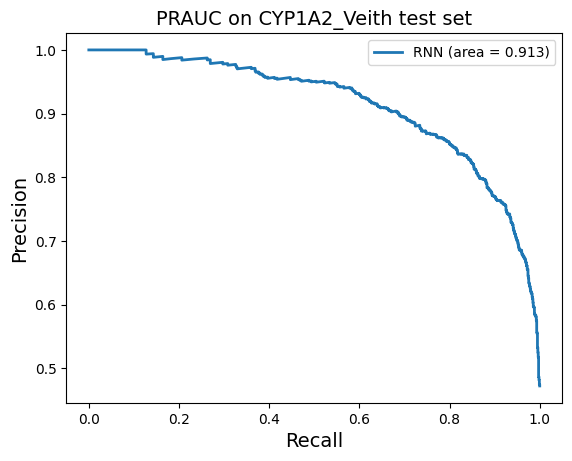


*************** CYP2C9_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.817  &0.803  &0.718  &0.758  &0.847  &0.738 &0.891 &0.598 &0.779


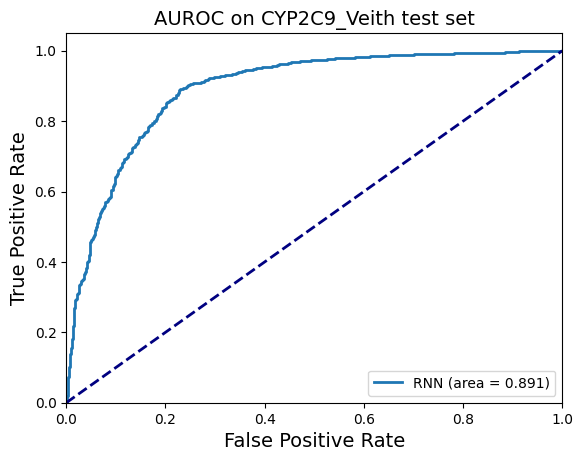

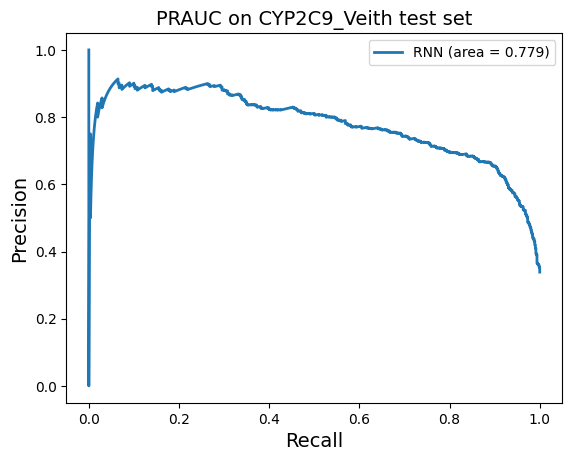



--> Train status saved at M5/uw/RNN_MT_0.yml
Finished evaluate test performance, outputs performance dict

Run # 1 for RNN MT	 | save dir:  M5/uw/RNN_MT_1 | 	cannot open M5/uw/RNN_MT_1.yml, retrain
Model type:  RNN | Model parameters:  2981257
Start training RNN...
Epoch:0 [Train] Loss: 0.641 | [Valid] Loss: 0.599	SAVE MODEL: loss: inf -> 0.599 | runtime: 1.218 ms
Epoch:1 [Train] Loss: 0.569 | [Valid] Loss: 0.544	SAVE MODEL: loss: 0.599 -> 0.544 | runtime: 1.240 ms
Epoch:2 [Train] Loss: 0.537 | [Valid] Loss: 0.542	SAVE MODEL: loss: 0.544 -> 0.542 | runtime: 1.220 ms
Epoch:3 [Train] Loss: 0.517 | [Valid] Loss: 0.526	SAVE MODEL: loss: 0.542 -> 0.526 | runtime: 1.221 ms
Epoch:4 [Train] Loss: 0.507 | [Valid] Loss: 0.507	SAVE MODEL: loss: 0.526 -> 0.507 | runtime: 1.214 ms
Epoch:5 [Train] Loss: 0.500 | [Valid] Loss: 0.520	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.498 | [Valid] Loss: 0.506	SAVE MODEL: loss: 0.507 -> 0.506 | runtime: 1.199 ms
Epoch:7 [Train] Loss: 0.497 | [

In [ ]:
from scripts.TRAIN import *
p = train_mt(M5, 'RNN', 'M5/uw', repeat_time=3, retrain=False, uw=True)

Start training MLP...
Epoch:0 [Train] Loss: 0.676 | [Valid] Loss: 0.669	SAVE MODEL: loss: inf -> 0.669 | runtime: 0.156 ms
Epoch:1 [Train] Loss: 0.645 | [Valid] Loss: 0.630	SAVE MODEL: loss: 0.669 -> 0.630 | runtime: 0.151 ms
Epoch:2 [Train] Loss: 0.592 | [Valid] Loss: 0.572	SAVE MODEL: loss: 0.630 -> 0.572 | runtime: 0.154 ms
Epoch:3 [Train] Loss: 0.522 | [Valid] Loss: 0.503	SAVE MODEL: loss: 0.572 -> 0.503 | runtime: 0.152 ms
Epoch:4 [Train] Loss: 0.449 | [Valid] Loss: 0.445	SAVE MODEL: loss: 0.503 -> 0.445 | runtime: 0.154 ms
Epoch:5 [Train] Loss: 0.389 | [Valid] Loss: 0.403	SAVE MODEL: loss: 0.445 -> 0.403 | runtime: 0.152 ms
Epoch:6 [Train] Loss: 0.346 | [Valid] Loss: 0.376	SAVE MODEL: loss: 0.403 -> 0.376 | runtime: 0.153 ms
Epoch:7 [Train] Loss: 0.320 | [Valid] Loss: 0.364	SAVE MODEL: loss: 0.376 -> 0.364 | runtime: 0.150 ms
Epoch:8 [Train] Loss: 0.302 | [Valid] Loss: 0.362	SAVE MODEL: loss: 0.364 -> 0.362 | runtime: 0.149 ms
Epoch:9 [Train] Loss: 0.292 | [Valid] Loss: 0.365	Ear

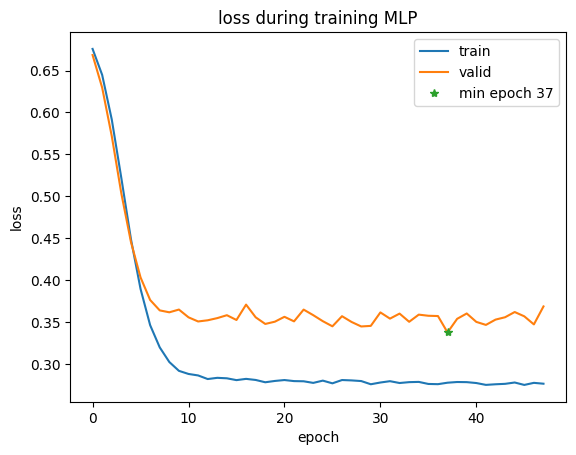

load pretrained model from  ckpt_ensemble.pt
[Test] Loss: 0.360
*************** CYP2C19_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.851  &0.851  &0.829  &0.851  &0.851  &0.840 &0.925 &0.701 &0.910


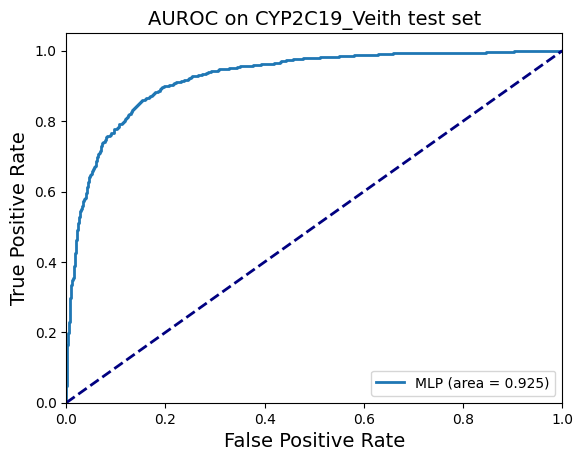

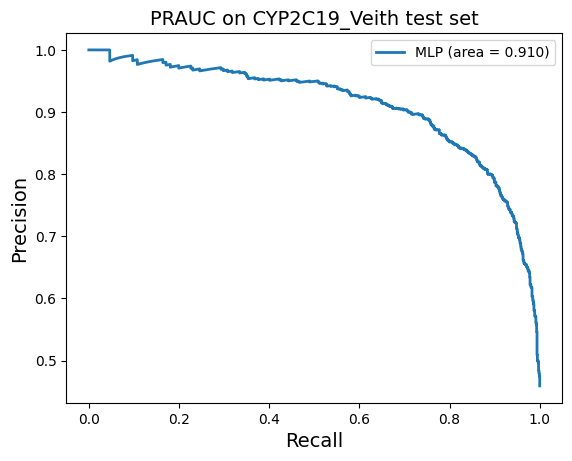



--> Train status saved at ckpt_ensemble.yml
Finished evaluate test performance, outputs performance dict


{'CYP2C19_Veith': [0.8511646269245954,
  0.8511708330456722,
  0.8291457286432161,
  0.8512467755803955,
  0.8510948905109489,
  0.8400509121764955,
  0.9250171027609191,
  0.7011422250844579,
  0.9104556511774436],
 'loss': 0.36002856824418594}

In [89]:
models.train(trn_l, val_l, tst_l)

In [76]:
optimizer = torch.optim.AdamW(model_ensemble.parameters(), lr=1e-5, weight_decay=1e-5)
train_epoch_MLP(model_ensemble, trn_l, False, [M5[0]], 'cuda', epoch=0,
                optimizer=optimizer, ver=True)

Epoch:0, [Train] Loss: 0.689


(0.6887164177894592, [172.1791044473648], [False])

In [34]:
def train_ensemble(task_name, data_loader, val_loader, test_loader=None,
                   model=model_ensemble, optimizer=optimizer):
    train_dict, valid_dict = {}, {}
    for epoch in range(0, 1000):
        score, l, r = train_epoch_MLP(model, data_loader, names_dict[task_name],
                                    [task_name], 'cuda', epoch, optimizer)
        val_score, probs, labels = train_epoch_MLP(model, val_loader,
                            names_dict[task_name], [task_name], 'cuda', epoch)
        print(f'Epoch:{epoch} [Train] Loss: {score:.3f} |',
              f'[Valid] Loss: {val_score:.3f}', end='\t')
        early_stop =


,MLP,AttentiveFP,GIN
0,0.012835,0.000461,0.001742
1,0.171973,0.238632,0.105827
2,0.791856,0.769059,0.739037
3,0.114098,0.027950,0.010032
4,0.015351,0.012458,0.002585
...,...,...,...
9235,0.194260,0.113300,0.118666
9236,0.835051,0.964382,0.963000
9237,0.661982,0.262997,0.290226
9238,0.373812,0.369131,0.095851


In [24]:
from torch.utils.data import DataLoader, Dataset
class ensemble_dataset(Dataset):
    def __init__(self, df, task_name, tst, mask=MASK, header=model_types[:3]):
        # task labels of task_name should be in tst which contains true label
        assert task_name in tst.columns
        # the order of smiles in df (prediction) should be the same as tst
        tst = tst.fillna(mask)
        self.tst = tst
        assert (df[0]['Drug'] == tst['Drug']).all() == True
        self.len = len(df)
        self.fp = self.d


In [16]:
df_list[0]

,Drug,MLP,AttentiveFP,GIN
0,Cc1cnc(CNc2cc(-c3ccc(N(C)C)cc3)ncn2)cn1,0.012835,0.000461,0.001742
1,Oc1ccc(CCNCc2cc3c(cc2Br)OCO3)cc1,0.171973,0.238632,0.105827
2,COc1ccccc1N1CCN(C(=O)/C=C/c2ccc3c(c2)OCO3)CC1,0.791856,0.769059,0.739037
3,C[C@@H]1CC[C@H]2[C@H](C)[C@H]3[C@H](C[C@H]4[C@...,0.114098,0.027950,0.010032
4,CCN1C[C@]2(C)CC[C@H](O)[C@]34[C@@H]1[C@@H](C[C...,0.015351,0.012458,0.002585
...,...,...,...,...
9235,COC(=O)C1=C(C)[C@@H](O)[C@@H](C)[C@H](c2c(OC)c...,0.194260,0.113300,0.118666
9236,COc1ccc(S(=O)(=O)N2Cc3ccccc3CC2C(=O)Nc2nccs2)cc1,0.835051,0.964382,0.963000
9237,Cc1ccc(N2C(=O)C3C4C=CC(C4)C3C2=O)cc1C,0.661982,0.262997,0.290226
9238,O=C(N/N=C/C=C/c1ccccc1)c1cc2c(ccc3ccccc32)o1,0.373812,0.369131,0.095851


In [4]:
import yaml
GIN_yml_path = 'M5/uw/GIN_MT_1.yml'
with open(GIN_yml_path, 'r') as f:
    yml_data = yaml.safe_load(f)
models = PRED(**yml_data['config'])
models.load_status(yml_data)

gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 55.6MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978801
finish load data status 



In [ ]:
trn, val, tst = collect_data(M5)

trn, val, tst, dict_scale = scale(trn, val, tst, yml_data['config']['scale_dict'])

In [6]:
trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, yml_data['config'])

---> loader for ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN


load pretrained model from  M5/uw/GIN_MT_1.pt
[Test] Loss: 0.207
*************** CYP2C19_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.859  &0.858  &0.841  &0.854  &0.863  &0.847 &0.927 &0.716 &0.912


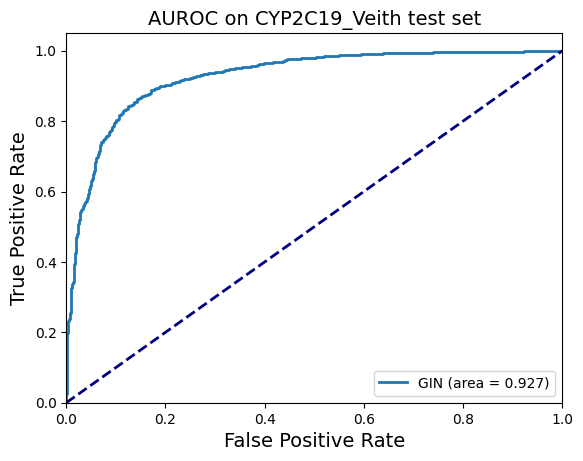

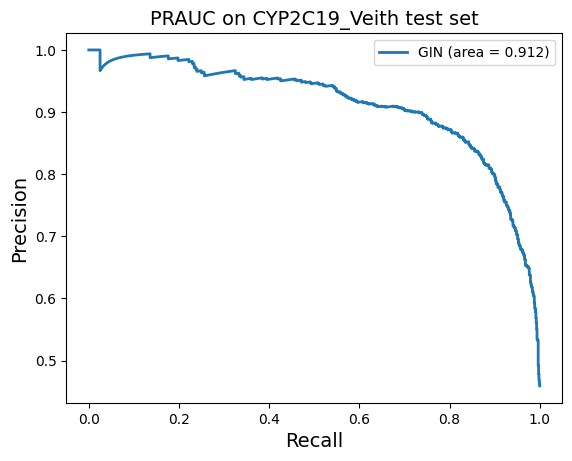


*************** CYP2D6_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.893  &0.783  &0.771  &0.607  &0.959  &0.679 &0.907 &0.622 &0.770


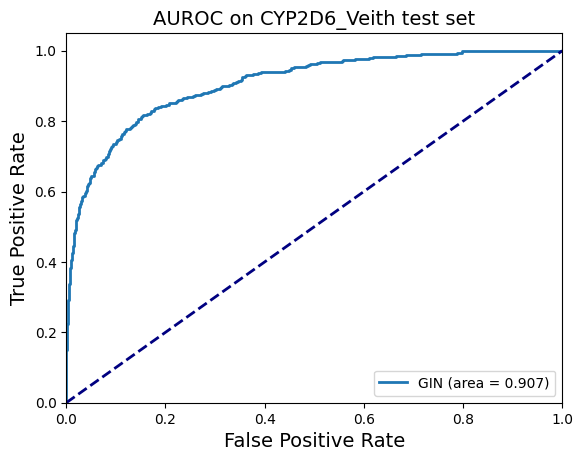

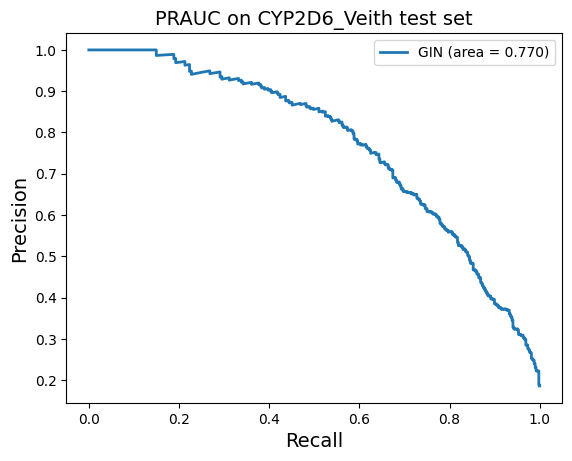


*************** CYP3A4_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.836  &0.830  &0.801  &0.800  &0.861  &0.801 &0.917 &0.661 &0.882


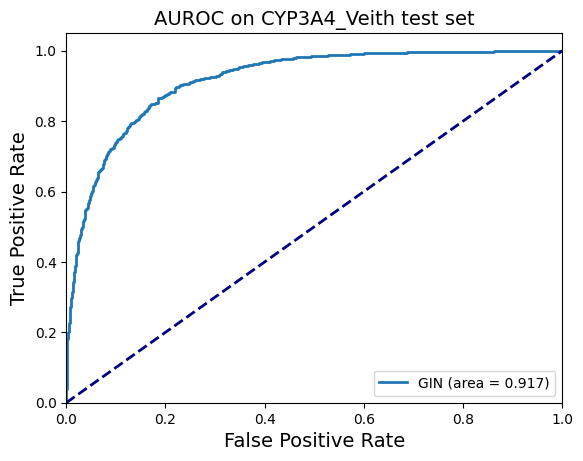

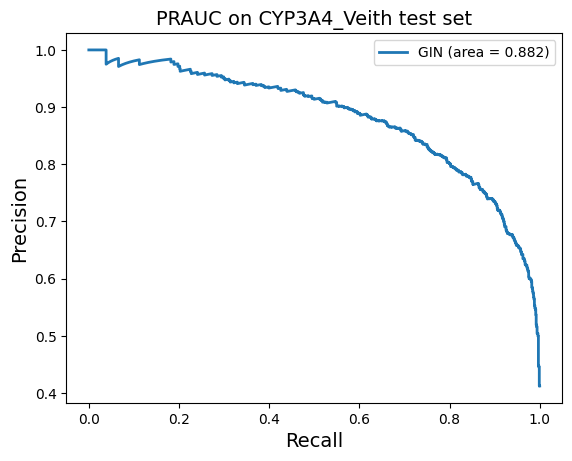


*************** CYP1A2_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.884  &0.883  &0.879  &0.875  &0.892  &0.877 &0.950 &0.767 &0.946


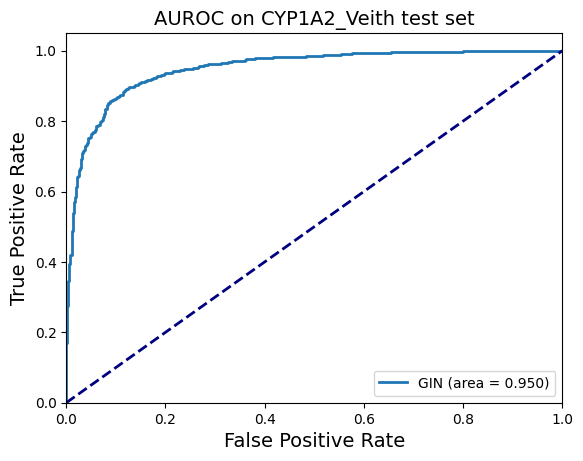

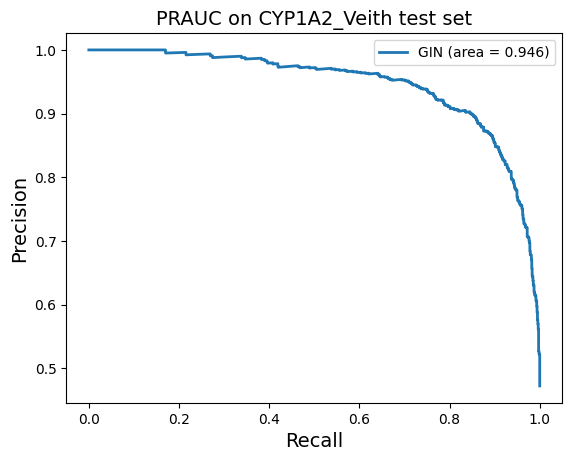


*************** CYP2C9_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.860  &0.840  &0.804  &0.777  &0.903  &0.790 &0.933 &0.686 &0.862


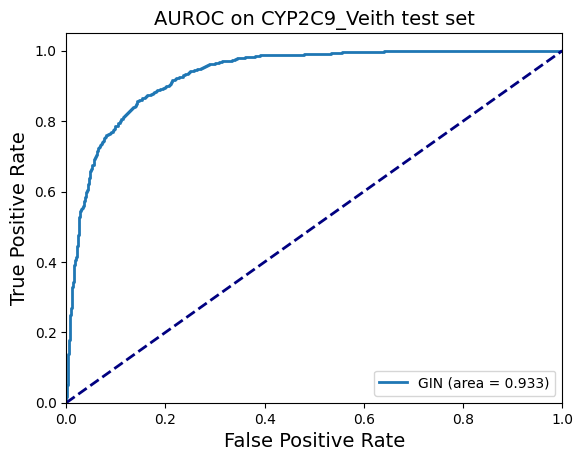

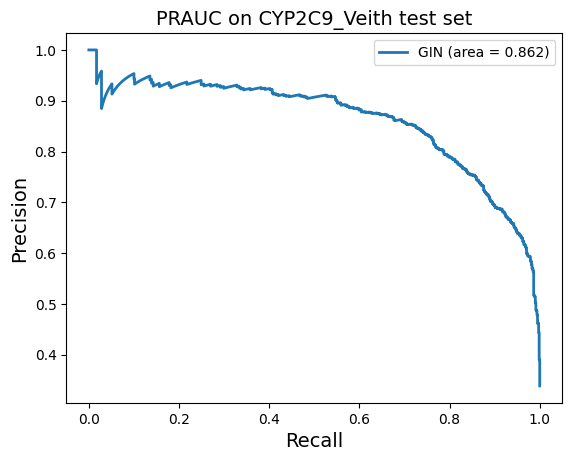

In [8]:
a = models.eval(tst_l)

In [10]:
df_GIN = models.predict(tst['Drug'].tolist(), return_probs=True)
df_GIN

load pretrained model from  M5/uw/GIN_MT_1.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 145/145 [00:19<00:00,  7.31it/s]


,Drug,CYP2C19_Veith,CYP2D6_Veith,CYP3A4_Veith,CYP1A2_Veith,CYP2C9_Veith
0,Cc1cnc(CNc2cc(-c3ccc(N(C)C)cc3)ncn2)cn1,0.053560,0.020103,0.683830,0.998558,0.001742
1,Oc1ccc(CCNCc2cc3c(cc2Br)OCO3)cc1,0.921345,0.988818,0.904874,0.963067,0.105827
2,COc1ccccc1N1CCN(C(=O)/C=C/c2ccc3c(c2)OCO3)CC1,0.832398,0.246632,0.952305,0.587138,0.739037
3,C[C@@H]1CC[C@H]2[C@H](C)[C@H]3[C@H](C[C@H]4[C@...,0.016996,0.278494,0.052509,0.005627,0.010032
4,CCN1C[C@]2(C)CC[C@H](O)[C@]34[C@@H]1[C@@H](C[C...,0.003304,0.014538,0.002292,0.000442,0.002585
...,...,...,...,...,...,...
9235,COC(=O)C1=C(C)[C@@H](O)[C@@H](C)[C@H](c2c(OC)c...,0.265648,0.012153,0.208359,0.063242,0.118666
9236,COc1ccc(S(=O)(=O)N2Cc3ccccc3CC2C(=O)Nc2nccs2)cc1,0.984733,0.441567,0.913700,0.683069,0.963000
9237,Cc1ccc(N2C(=O)C3C4C=CC(C4)C3C2=O)cc1C,0.356279,0.039796,0.847792,0.019778,0.290226
9238,O=C(N/N=C/C=C/c1ccccc1)c1cc2c(ccc3ccccc32)o1,0.097825,0.006044,0.041897,0.952402,0.095851


In [9]:
tst

,Drug,CYP2C19_Veith,CYP2D6_Veith,CYP3A4_Veith,CYP1A2_Veith,CYP2C9_Veith
0,Cc1cnc(CNc2cc(-c3ccc(N(C)C)cc3)ncn2)cn1,0.0,NaN,NaN,NaN,NaN
1,Oc1ccc(CCNCc2cc3c(cc2Br)OCO3)cc1,1.0,NaN,NaN,NaN,NaN
2,COc1ccccc1N1CCN(C(=O)/C=C/c2ccc3c(c2)OCO3)CC1,1.0,NaN,1.0,NaN,NaN
3,C[C@@H]1CC[C@H]2[C@H](C)[C@H]3[C@H](C[C@H]4[C@...,0.0,1.0,NaN,0.0,NaN
4,CCN1C[C@]2(C)CC[C@H](O)[C@]34[C@@H]1[C@@H](C[C...,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
9235,COC(=O)C1=C(C)[C@@H](O)[C@@H](C)[C@H](c2c(OC)c...,NaN,NaN,NaN,NaN,0.0
9236,COc1ccc(S(=O)(=O)N2Cc3ccccc3CC2C(=O)Nc2nccs2)cc1,NaN,NaN,NaN,NaN,1.0
9237,Cc1ccc(N2C(=O)C3C4C=CC(C4)C3C2=O)cc1C,NaN,NaN,NaN,NaN,0.0
9238,O=C(N/N=C/C=C/c1ccccc1)c1cc2c(ccc3ccccc32)o1,NaN,NaN,NaN,NaN,0.0
